# Semantic Projections Assignment 📘

This notebook will guide you through an exercise on **semantic projections** using pre-trained word embeddings.  
We will:
1. Download pre-trained embeddings (GloVe).
2. Define a semantic direction (e.g., gender).
3. Project words onto this direction.
4. Visualize the results in 2D using PCA.
5. Reflect on the meaning of these projections.

---

### In the commented code where it says **TODO**, you should complete it and make it functional.

## 1. Setup
We will start by installing the required libraries and downloading GloVe embeddings.

In [1]:
#!pip install gensim
import gensim.downloader as api

# Load pretrained GloVe (100d)
embeddings_index = api.load("glove-wiki-gigaword-100")
print(f"Loaded {len(embeddings_index.key_to_index)} word vectors.")

[==================================================] 100.0% 128.1/128.1MB downloaded
Loaded 400000 word vectors.


## 2. Defining a Semantic Direction
To explore projections, we need a **semantic direction**.
For this example, let's define the **gender direction**:
$$ d_{gender} = vec_{he} - vec_{she} $$
Where the semantic direction $$ d _{gender} $$ is the relation between the male $$vec_{he}$$ direction and the female $$vec_{she}$$ direction.

In [2]:
import numpy as np

# Define the gender direction
gender_direction = embeddings_index["he"] - embeddings_index["she"]
print("Gender direction vector created (shape):", gender_direction.shape)

Gender direction vector created (shape): (100,)


In [3]:
# Helper function to create a semantic direction between any two words
def semantic_direction(word1, word2, embeddings):
    return embeddings[word1] - embeddings[word2]

# Example: royalty direction
royalty_direction = semantic_direction("king", "queen", embeddings_index)
print("Royalty direction vector created (shape):", royalty_direction.shape)

Royalty direction vector created (shape): (100,)


## 3. Projecting Words
The projection of a word embedding onto the semantic direction is given by:

$$
\operatorname{proj}_{\mathbf{d}}(\mathbf{w})
= \frac{\mathbf{w}\cdot\mathbf{d}}{\|\mathbf{d}\|^2}\,\mathbf{d}
$$

Equivalently, the scalar coefficient is
$$
\alpha = \frac{\mathbf{w}\cdot\mathbf{d}}{\|\mathbf{d}\|^2},
\quad
\operatorname{proj}_{\mathbf{d}}(\mathbf{w}) = \alpha\,\mathbf{d}
$$

In [12]:
# Function to compute projection of a word onto a direction
def project_word(word, direction, embeddings):
    vec = embeddings[word]
    projection = (np.dot(vec, direction) / np.dot(direction, direction)) * direction
    return projection

# Test with some words
words_to_test = ["man", "woman", "king", "queen", "doctor", "nurse"]
for w in words_to_test:
    proj = project_word(w, gender_direction, embeddings_index)
    score = np.dot(embeddings_index[w], gender_direction)
    print(f"{w}: projection score along gender axis = {score:.4f}")

man: projection score along gender axis = 0.3989
woman: projection score along gender axis = -6.7592
king: projection score along gender axis = 2.9095
queen: projection score along gender axis = -5.1355
doctor: projection score along gender axis = -1.1747
nurse: projection score along gender axis = -5.2384


In [37]:
# Testing with other words
words_to_test2 = ["son", "grandfather", "brother", "sister", "girlfriend", "aunt", "wife", "husband"]
for w in words_to_test2:
    proj = project_word(w, gender_direction, embeddings_index)
    score = np.dot(embeddings_index[w], gender_direction)
    print(f"{w}: projection score along gender axis = {score:.4f}")

son: projection score along gender axis = 0.3633
grandfather: projection score along gender axis = -0.0361
brother: projection score along gender axis = 0.9388
sister: projection score along gender axis = -7.4718
girlfriend: projection score along gender axis = -7.1325
aunt: projection score along gender axis = -6.9974
wife: projection score along gender axis = -6.0064
husband: projection score along gender axis = -4.7636


## 4. Visualization in 2D (PCA)
We will project embeddings and their semantic projections into **2D space** using PCA for visualization.

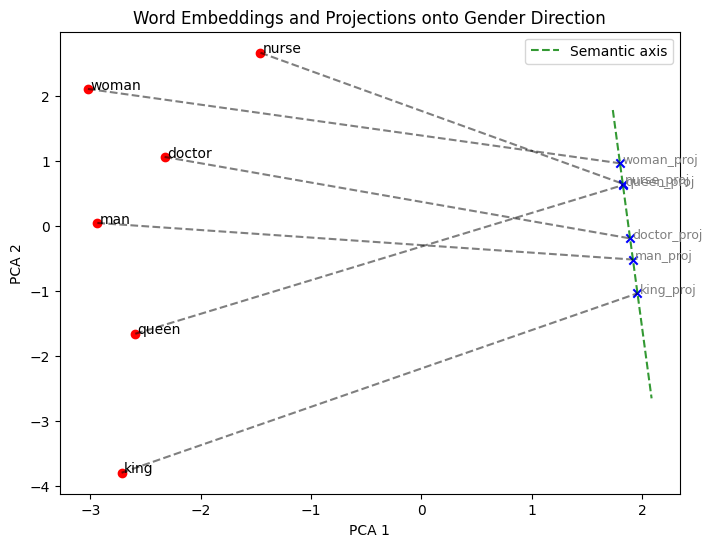

In [31]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def visualize_projections(words, direction, embeddings, title):
    vectors = [embeddings[w] for w in words]
    projections = [project_word(w, direction, embeddings) for w in words]

    # Apply PCA to reduce dimension to 2D
    pca = PCA(n_components=2)
    all_points = np.vstack([vectors, projections, direction.reshape(1, -1), -direction.reshape(1, -1)])
    reduced = pca.fit_transform(all_points)

    n = len(words)
    orig_points = reduced[:n]
    proj_points = reduced[n:2*n]
    dir_plus = reduced[-2]
    dir_minus = reduced[-1]

    plt.figure(figsize=(8,6))

    # Plot the semantic axis line
    plt.plot(
        [dir_minus[0], dir_plus[0]],
        [dir_minus[1], dir_plus[1]],
        'g--', alpha=0.8, label="Semantic axis"
    )

    for i, word in enumerate(words):
        # Original word
        plt.scatter(orig_points[i,0], orig_points[i,1], color='red')
        plt.text(orig_points[i,0]+0.02, orig_points[i,1], word, fontsize=10)

        # Projection
        plt.scatter(proj_points[i,0], proj_points[i,1], color='blue', marker='x')
        plt.text(proj_points[i,0]+0.02, proj_points[i,1], word+"_proj", fontsize=9, color='gray')

        # Connecting dashed line
        plt.plot(
            [orig_points[i,0], proj_points[i,0]],
            [orig_points[i,1], proj_points[i,1]],
            'k--', alpha=0.5
        )

    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend()
    plt.show()

# Example visualization: gender axis
visualize_projections(words_to_test, gender_direction, embeddings_index,
                      "Word Embeddings and Projections onto Gender Direction")


## 5. Reflection
- What do you observe about the position of words like *king/queen* and *man/woman*?
- Do professions like *doctor* or *nurse* show bias when projected?
- How could you use this technique to **debias embeddings**?
---


# Reflection
1. The position of man/woman are almost the limits of the projection. Related to king/queen, apparently are closed, but in the projection are overlapping the position of the "top class" of the projection (man and woman).
2. Yes. The bias is evident: Nurse is assumed as a female profession, and  doctor is projected as a male role.
3. One approach is to project embeddings into a “debiased” space by mathematically removing bias directions. For example, if gender bias is detected, we can compute the dominant gender-related direction in the embedding space (e.g., “man” minus “woman” vectors) and subtract this component from all embeddings.
Like: $$ \operatorname{bias}
= \vec{man} - \vec{woman} $$
and then the new embeddings will be:
$$ \operatorname{unbiassed}
= \vec{original} - \vec{bias} $$

## ✅ Final Task: Extend this notebook by trying a different semantic direction, e.g.,
$$
\operatorname{royalty}
= \vec{king} - \vec{queen} $$
and analyze the projections.

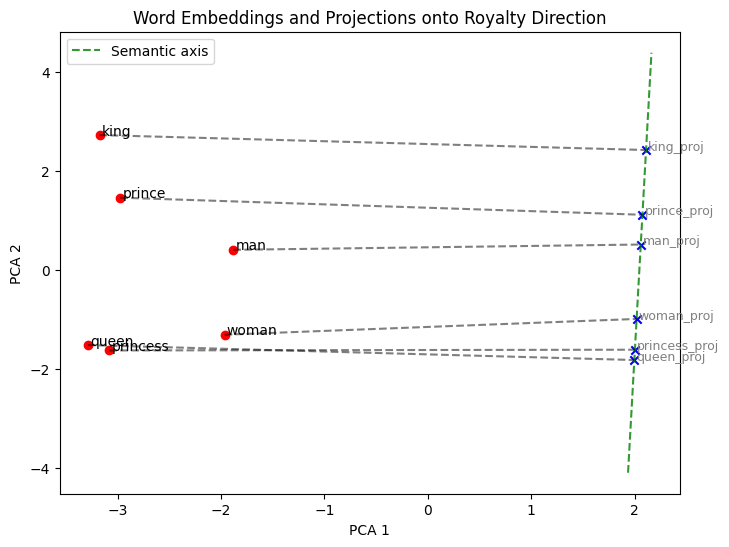

In [32]:
# Example with royalty direction
royalty_words = ["king", "queen", "prince", "princess", "man", "woman"]

visualize_projections(royalty_words, royalty_direction, embeddings_index, "Word Embeddings and Projections onto Royalty Direction")

In [20]:
# Example: gender bias direction
bias_direction = embeddings_index["king"] - embeddings_index["queen"]
bias_direction = bias_direction / np.linalg.norm(bias_direction)  # normalize

def debias_vector(v, bias_dir):
    """
    Remove the component of vector v that lies along bias_dir.
    """
    bias_component = np.dot(v, bias_dir) * bias_dir
    return v - bias_component

words = ["doctor", "nurse", "king", "queen", "teacher", "engineer"]

debiased_embeddings = {}
for w in words:
    v = embeddings_index[w]
    debiased_embeddings[w] = debias_vector(v, bias_direction)



With the previous operation, we have the actual debiased embeddings vector.
After that, we can check the differences in the projections.

In [33]:
def projection_strength(v, bias_dir):
    return np.dot(v, bias_dir)

print("Before debiasing:")
for w in words:
    print(f"{w:10s} -> {projection_strength(embeddings_index[w], bias_direction):.4f}")

print("\nAfter debiasing:")
for w in words:
    print(f"{w:10s} -> {projection_strength(debiased_embeddings[w], bias_direction):.4f}")


Before debiasing:
doctor     -> 0.3267
nurse      -> -1.0785
king       -> 2.2976
queen      -> -1.9836
teacher    -> -0.1252
engineer   -> 0.5061

After debiasing:
doctor     -> -0.0000
nurse      -> 0.0000
king       -> -0.0000
queen      -> -0.0000
teacher    -> -0.0000
engineer   -> -0.0000


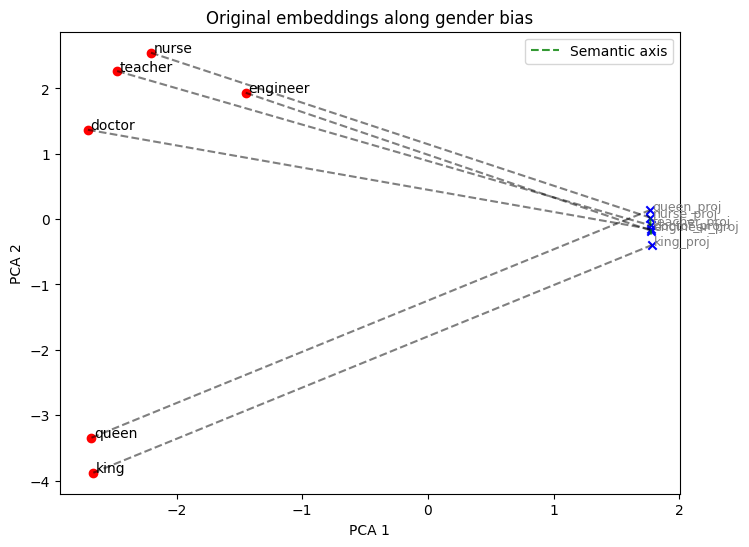

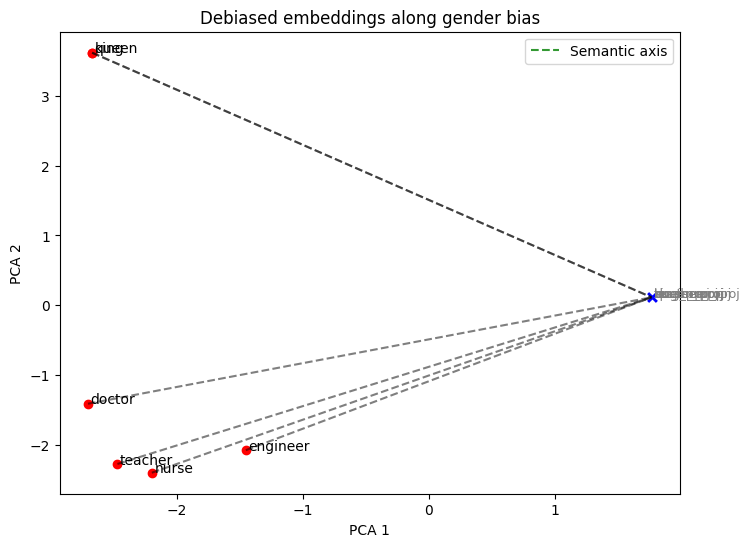

In [34]:
# Visualize before and after
visualize_projections(words, bias_direction, embeddings_index,
                      "Original embeddings along gender bias")

visualize_projections(words, bias_direction, debiased_embeddings,
                      "Debiased embeddings along gender bias")


But... are all the words actually in the same position?

In [35]:
from numpy.linalg import norm

def cosine_similarity(a, b):
    return np.dot(a, b) / (norm(a) * norm(b))

print("Cosine similarity between doctor and nurse:")
print("Before:", cosine_similarity(embeddings_index["doctor"], embeddings_index["nurse"]))
print("After: ", cosine_similarity(debiased_embeddings["doctor"], debiased_embeddings["nurse"]))


Cosine similarity between doctor and nurse:
Before: 0.75215083
After:  0.78113216


In the projection, after the debiasing, that projection is exactly zero for all vectors (as expected!) All -0.0000.
It does not mean the vectors are identical — they still differ in the orthogonal subspace.

##Next steps: full Hard Debiasing algorithm
(Bolukbasi et al. 2016).

The main things to consider:\
🔹 Step 1: Neutralization.\
 Done, the gender information was removed.\
🔹 Step 2: Equalization

For word pairs that should be symmetric along the bias direction (like man–woman, king–queen), we need to compute their mean vector, then remove the bias component from that mean. And after that...\
Both words will be equally distant along the bias axis, but centered around the debiased mean.
→ This ensures both words are equally far from the bias direction, restoring symmetry.



In [39]:
# --- Step 1: Neutralization ---
## Same code as in previous cells

# --- Step 2: Equalization ---
def equalize_pair(w1, w2, embeddings, bias_dir):
    """
    Equalize embeddings of a pair of words (e.g., 'man', 'woman').
    """
    v1, v2 = embeddings[w1], embeddings[w2]
    mean = (v1 + v2) / 2

    # Step A: neutralize the mean
    mean_neutral = debias_vector(mean, bias_dir)

    # Step B: compute bias component for each vector
    v1_bias = np.dot(v1, bias_dir) * bias_dir
    v2_bias = np.dot(v2, bias_dir) * bias_dir

    # Step C: adjust vectors to be symmetric around the neutral mean
    corrected_bias = (v1_bias - v2_bias) / 2
    v1_new = mean_neutral + corrected_bias
    v2_new = mean_neutral - corrected_bias

    return v1_new, v2_new


In [42]:
# Words to neutralize
neutral_words = ["doctor", "nurse", "teacher", "engineer"]

# Word pairs to equalize
equalize_pairs = [("man", "woman"), ("king", "queen"), ("he", "she"), ("male", "female"), ("lion", "lioness")]

# Apply debiasing
debiased_embeddings = {}

# Neutralize
for w in neutral_words:
    debiased_embeddings[w] = debias_vector(embeddings_index[w], bias_direction)

# Equalize
for w1, w2 in equalize_pairs:
    v1, v2 = equalize_pair(w1, w2, embeddings_index, bias_direction)
    debiased_embeddings[w1] = v1
    debiased_embeddings[w2] = v2


In [43]:
def projection_strength(v, bias_dir):
    return np.dot(v, bias_dir)

print("Before debiasing:")
for w in neutral_words + [w for pair in equalize_pairs for w in pair]:
    print(f"{w:10s} -> {projection_strength(embeddings_index[w], bias_direction):.4f}")

print("\nAfter debiasing:")
for w in neutral_words + [w for pair in equalize_pairs for w in pair]:
    print(f"{w:10s} -> {projection_strength(debiased_embeddings[w], bias_direction):.4f}")


Before debiasing:
doctor     -> 0.3267
nurse      -> -1.0785
teacher    -> -0.1252
engineer   -> 0.5061
man        -> 0.3711
woman      -> -1.1461
king       -> 2.2976
queen      -> -1.9836
he         -> 0.7930
she        -> -1.0861
male       -> -1.0886
female     -> -1.4815
lion       -> 0.3307
lioness    -> -0.6566

After debiasing:
doctor     -> -0.0000
nurse      -> 0.0000
teacher    -> -0.0000
engineer   -> -0.0000
man        -> 0.7586
woman      -> -0.7586
king       -> 2.1406
queen      -> -2.1406
he         -> 0.9396
she        -> -0.9396
male       -> 0.1964
female     -> -0.1964
lion       -> 0.4936
lioness    -> -0.4936


We can visualize (calling the visualization functions previously included).